In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Q1: value iterations

let's incode the states and the actions:

In [12]:
# we encode the space as follow:
#
#          |20|
# |17|18|19| 0| 1| 2| 3|
# |16|     |21|     | 4|
# |15|              | 5|
# |14|     |22|     | 6|
# |13|12|11|10| 9| 8| 7|

states_given_up = {0:20,4:3,5:4,6:5,7:6,10:22,13:14,14:15,15:16,16:17,21:0}
states_given_down = {20:0,0:21,3:4,4:5,5:6,6:7,17:16,16:15,15:14,14:13}
states_given_left = {3:2,2:1,1:0,0:19,19:18,18:17,7:8,8:9,9:10,10:11,12:13}
states_given_right = {17:18,18:19,19:0,0:1,1:2,2:3,13:12,12:11,11:10,10:9,9:8,8:7}

actions_to_moves = {0:states_given_up,
                    1:states_given_down,
                    2:states_given_left,
                    3:states_given_right,
                    4:{}}

n_actions = 5
n_states = 23

then the reward function and transition probabilities (viewed as 3-dimension tables)

In [13]:
def init_P_and_R():
    P = np.zeros((n_actions,n_states,n_states))
    for action in range(n_actions):
        for state in range(n_states):
            move = actions_to_moves[action]
            if state in move:
                P[action,state,state] = 0.1
                if move[state] in move:
                    P[action,state,move[state]] = 0.75
                    P[action,state,move[move[state]]] = 0.15
                else:
                    P[action,state,move[state]] = 0.9
            else:
                P[action,state,state] = 1.
    R = np.zeros((n_actions,n_states,n_states))
    R[1,0,21] = -100
    R[0,10,22] = 10
    return P,R

let's init V and parameters:

In [14]:
P,R = init_P_and_R()
V = np.zeros(n_states)
gamma = 0.95
maximal_time = 100

we run value iterations:

In [15]:
for t in range(maximal_time):
    new_V = np.max(np.sum(P*(R + gamma*np.tile(V,(n_actions,n_states,1))),2),0)
    V = new_V

resulting optimal Q* and policy

In [18]:
Q_star = np.sum(P*(R + gamma*np.tile(V,(n_actions,n_states,1))),2)
policy = np.argmax(Q_star,0)
#print(Q_star)
print(policy)

[2 3 3 1 1 1 1 2 2 2 0 3 3 3 1 1 1 1 2 2 1 0 0]


## Q2: convergency

let's do it again, knowing $Q*$

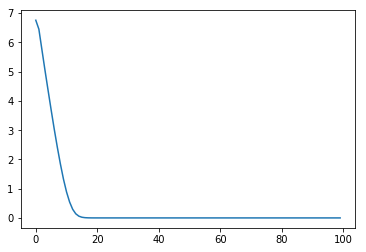

In [19]:
V = np.zeros(n_states)
epsilons = []

for t in range(maximal_time):
    Q_k = np.sum(P*(R + gamma*np.tile(V,(n_actions,n_states,1))),2)
    new_V = np.max(Q_k,0)
    epsilons.append(np.mean(np.abs(Q_star-Q_k)))
    V = new_V

plt.plot(epsilons)
plt.show()

we see that value iterations are realy effective for this MDP with only 18 iterations to reach optimal values

## Q3: Q-learning

let's init Q and parameters

In [40]:
Q = np.random.rand(n_actions, n_states)
state = 20
gamma = 0.95
alpha = 0.05
epsilon = 0.2
maximal_time = 200000
epsilons = []

we quickly implemente eps-greedy function:

In [41]:
def epsilon_greedy(values):
    action = np.argmax(values)
    if np.random.rand()<epsilon:
        action = np.random.choice(n_actions)
    return action

and we run Q-learning loop:

In [42]:
for t in range(maximal_time):
    action = epsilon_greedy(Q[:,state])
    new_state = np.random.choice(n_states, p=(P[action,state,:]))
    reward = R[action,state,new_state]
    done = 0
    if new_state==22:
        new_state = 20
        done = 1
    Q[action,state] += alpha*(reward + (1-done)*gamma*np.max(Q[:,new_state]) - Q[action,state])
    epsilons.append(np.mean(np.abs(Q_star-Q)))
    state = new_state

let see the resulting policy and the convergency to Q*:

[3 3 3 1 1 1 1 2 2 2 0 3 3 3 1 1 1 1 3 3 1 0 4]


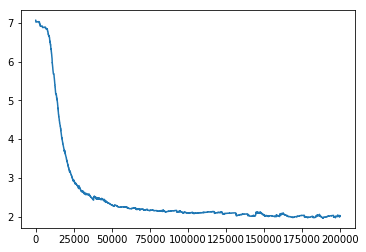

In [43]:
#print(Q)
policy = np.argmax(Q,0)
print(policy)
plt.plot(epsilons)
plt.show()

The policy is sometime optimal after 200000 iteration, but not allways and can present small suboptimalities  (for exemple it goes right in states 18 and 19). We also observe difference where there is an arbitrary choice (left or right after first step, action in terminal state)

concerning convergency to $Q*$, we see how Q-learning was inefficient comparing to value iterations, and it tends to  Q-values close but different than $Q*$.

## Q4: SARSA

let's init Q and parameters

In [44]:
Q = np.random.rand(n_actions,n_states)
state = 20
action = epsilon_greedy(Q[:,state])
gamma = 0.95
alpha = 0.05
epsilon = 0.2
maximal_time = 200000
epsilons = []

and we run SARSA loop:

In [45]:
for t in range(maximal_time):
    new_state = np.random.choice(n_states, p=(P[action,state,:]))
    reward = R[action,state,new_state]
    done = 0
    if new_state==22:
        new_state = 20
        done = 1
    new_action = epsilon_greedy(Q[:,new_state])
    Q[action,state] += alpha*(reward + (1-done)*gamma*Q[new_action,new_state] - Q[action,state])
    epsilons.append(np.mean(np.abs(Q_star-Q)))
    state = new_state
    action = new_action

let see the resulting policy and the convergency to Q*:

[3 3 3 1 1 1 1 2 2 2 0 3 3 3 1 1 1 1 2 2 3 0 1]


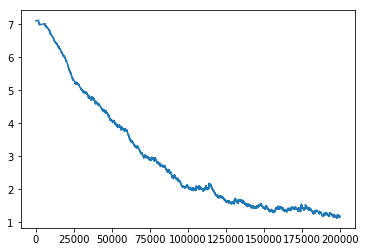

In [46]:
#print(Q)
policy = np.argmax(Q,0)
print(policy)
plt.plot(epsilons)
plt.show()

Again, the policy is sometime optimal after 200000 iteration, but not allways and can present small suboptimalities (for exemple it goes right in states 18 and 19). We also observe difference where there is an arbitrary choice (left or right after first step, action in terminal state)

concerning convergency to $Q*$, SARSA was also inefficient comparing to value iterations and even slower than Q-learning. After 200000, it seems tending to Q-values a bit closer to $Q*$ than with Q-learning (but maybe it's luck).